In [1]:
import numpy as np
import sys
import os
import re
import cv2
import trimesh
import tetgen 
import time
import gmsh
import meshio 

import matplotlib.pyplot as plt
import SimpleITK as sitk
import pymeshfix as pfix
import pyvista as pv
import skimage.morphology as skm
import iso2mesh as i2m
import pygalmesh as pygm

from iso2mesh import plotmesh
from skimage import io
from scipy import ndimage as ndi
from skimage.filters import threshold_otsu
from tqdm.notebook import tqdm
from skimage.transform import resize
from typing import Any, Dict, Optional, Tuple, List

sys.path.append('./src')  # to import alveoRVE from parent directory

from alveoRVE.plot.mpl import show_four_panel_volume
from alveoRVE.plot.pv import view_surface

%load_ext autoreload
%autoreload 2

In [2]:
def matlab_to_python_conv(no, fc): 
    no_out = no[:, :3].copy()
    fc_out = (np.atleast_2d(fc).astype(np.int64)[:, :3] - 1).astype(np.int32)
    return no_out, fc_out

In [3]:
folder         = "/mnt/c/Users/bherr/Downloads/CT-1um/images_reconstructed_1um"
border_px      = 0
resize_factor  = 1.5
offset_xyz     = (1,1,1)
width_incl     = 30
thr_binary     = 0.5
thr            = 25/255

### Loading

In [4]:
files = [f for f in os.listdir(folder) if f.lower().endswith(".bmp")]
# numeric sort by the largest integer in filename
def key(f): 
    m = re.findall(r"\d+", f)
    return int(m[-1]) if m else -1
paths = [os.path.join(folder, f) for f in sorted(files, key=key)]

offset_rve_x = 1000 # 1000 um = 1 mm
offset_rve_y = 1250
offset_rve_z = 1000
size_rve_x   = 500
size_rve_y   = 500
size_rve_z   = 500

reload = True
out_name = f"data/rve_1um_new_{offset_rve_x}_{offset_rve_y}_{offset_rve_z}_{size_rve_x}_{size_rve_y}_{size_rve_z}.npz"

try:
    data = np.load(out_name)
    vol = data['vol']
    print(f"[reload] Volume shape: {vol.shape}")
    print(f"[reload] Volume min/max: {vol.min()}/{vol.max()}")
except: 
    imgs = []
    for i, p in enumerate(tqdm(paths[offset_rve_z:offset_rve_z+size_rve_z], desc="Reading BMP stack")):
        img = cv2.imread(p, cv2.IMREAD_UNCHANGED)[offset_rve_x:offset_rve_x+size_rve_x, offset_rve_y:offset_rve_y+size_rve_y].astype(np.float32) # / 65535.0
        if i == 0: 
            full_img = cv2.imread(p, cv2.IMREAD_UNCHANGED).astype(np.float32)
            print(f"[read_bmp_stack] First image shape: {img.shape}, min/max: {img.min()}/{img.max()}")
            plt.imshow(full_img, cmap='gray')
            # add red rectangle to show RVE location
            plt.gca().add_patch(plt.Rectangle((offset_rve_y, offset_rve_x), size_rve_y, size_rve_x, edgecolor='red', facecolor='none', lw=2))
            
            plt.show()
        imgs.append(img)
    vol = np.stack(imgs)  # [Z,Y,X]
    print(f"[read_bmp_stack] Final volume shape: {vol.shape}")
    print(f"[read_bmp_stack] Volume min/max: {vol.min()}/{vol.max()}")
    vol /= vol.max()
    print(f"[read_bmp_stack] Volume min/max after normalization: {vol.min()}/{vol.max()}")

    np.savez_compressed(out_name, vol=vol)

[reload] Volume shape: (500, 500, 500)
[reload] Volume min/max: 0.0/1.0


### Resizing + segmenting 

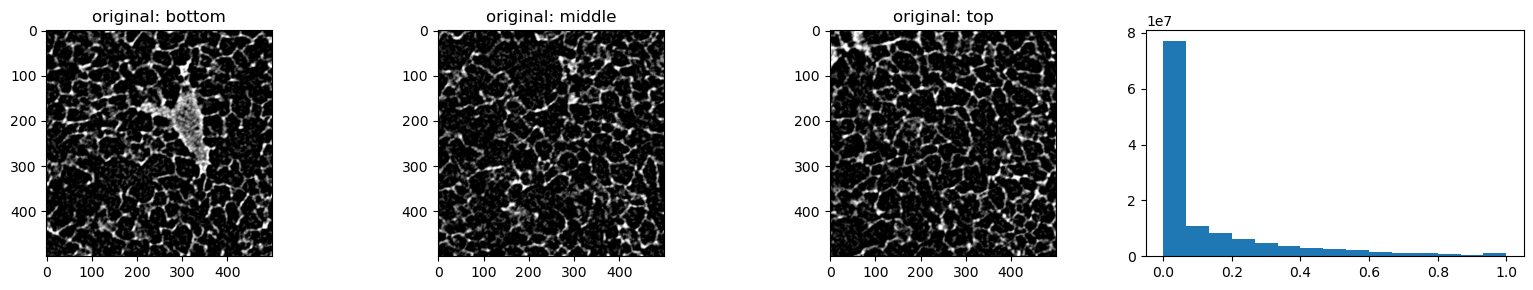

In [5]:
# print(f"unique values in vol: {np.unique(vol, return_counts=True)}")
_ = show_four_panel_volume(vol, title_prefix="original", is_binary=True)

porosity original: 0.8722


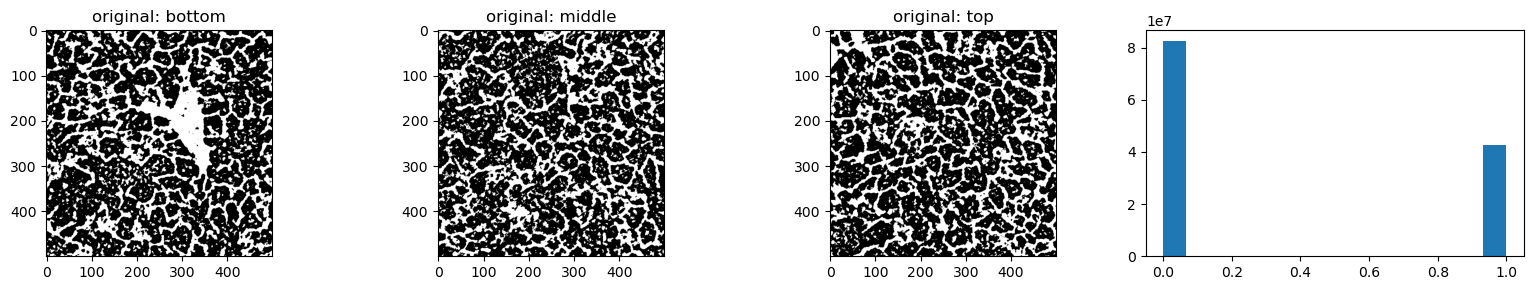

In [6]:
_ = show_four_panel_volume(vol>25/255, title_prefix="original", is_binary=True)
print(f"porosity original: {1.0 - (np.sum(vol) / vol.size):.4f}")

In [7]:
resize_factor = 2
offset_xyz = (40,40,20)
width_inclusive = 60

In [8]:
vol_c = vol[offset_xyz[0]:offset_xyz[0]+width_inclusive,
            offset_xyz[1]:offset_xyz[1]+width_inclusive,
            offset_xyz[2]:offset_xyz[2]+width_inclusive]

[resize] new porosity: 0.8634
[resize] new shape: (120, 120, 120)


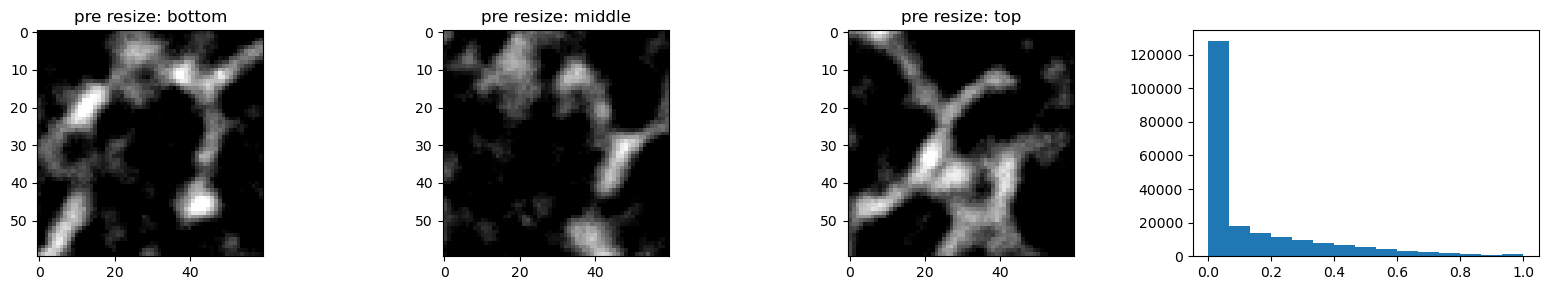

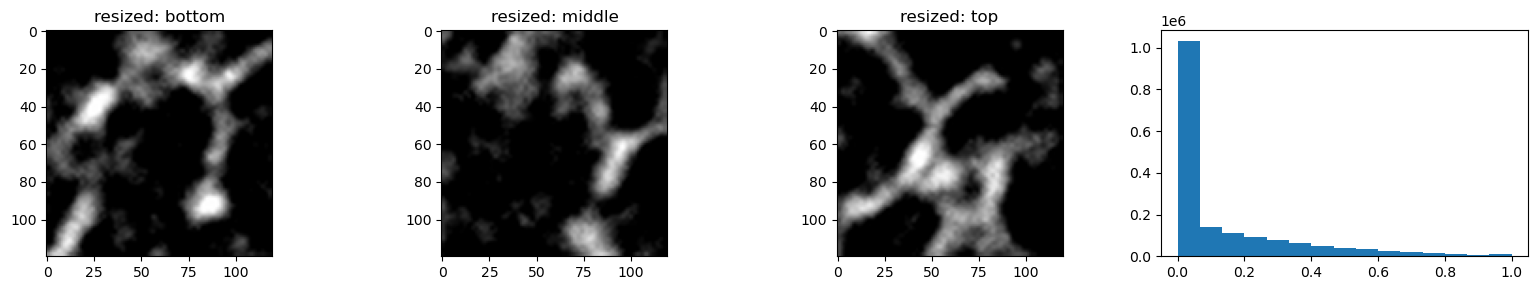

In [9]:
z, y, x = vol_c.shape
new_shape = (int(round(z*resize_factor)), int(round(y*resize_factor)), int(round(x*resize_factor)))

_ = show_four_panel_volume(vol_c, title_prefix="pre resize", is_binary=True)

out = resize(
        vol_c, #.astype(np.float32),
        new_shape,
        order=3, 
        # mode="edge", 
        anti_aliasing=True, 
        preserve_range=True
    ).astype(vol_c.dtype)

_ = show_four_panel_volume(out, title_prefix="resized", is_binary=True)

porosity_out = 1.0 - (np.sum(out) / out.size)
print(f"[resize] new porosity: {porosity_out:.4f}")
# print(f"unique values in out: {np.unique(out, return_counts=True)}")
print(f"[resize] new shape: {out.shape}")

starting filtering pipeline
denoised with Curvature Anisotropic Diffusion, time: 1.73 s


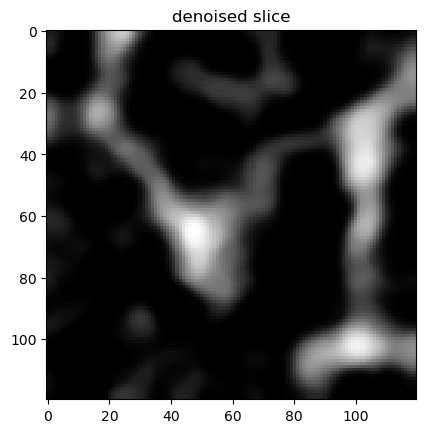

thresholded to remove low-valued pixels, time: 0.01 s


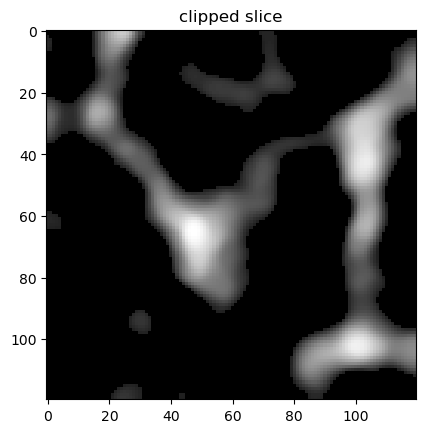

contrast enhanced with Adaptive Histogram Equalization, time: 1.76 s


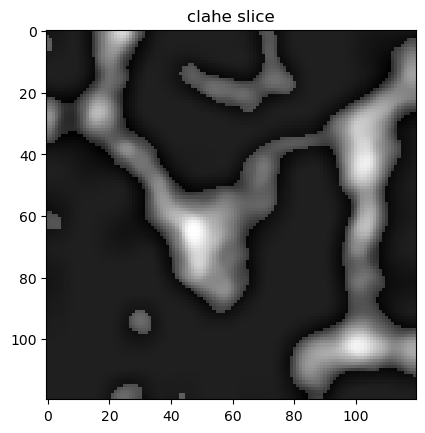

thresholded to binary image, time: 4.66 s


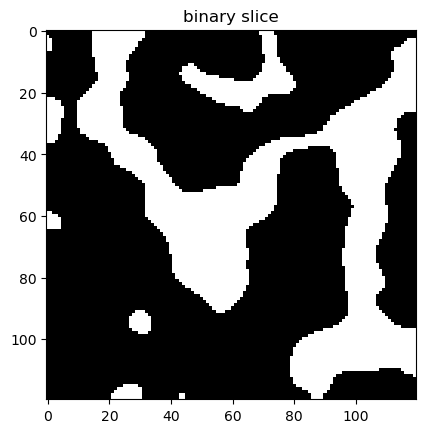

converted to NumPy array, time: 0.00 s
removed small objects, time: 0.02 s


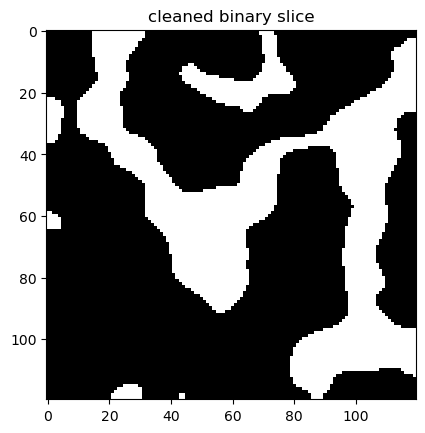

thinned slice-by-slice, time: 0.06 s
removed small objects after thinning, time: 0.02 s
removed small holes, time: 0.02 s


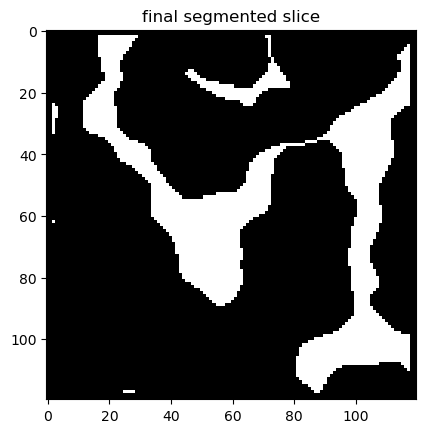

final porosity segmented: 0.7830


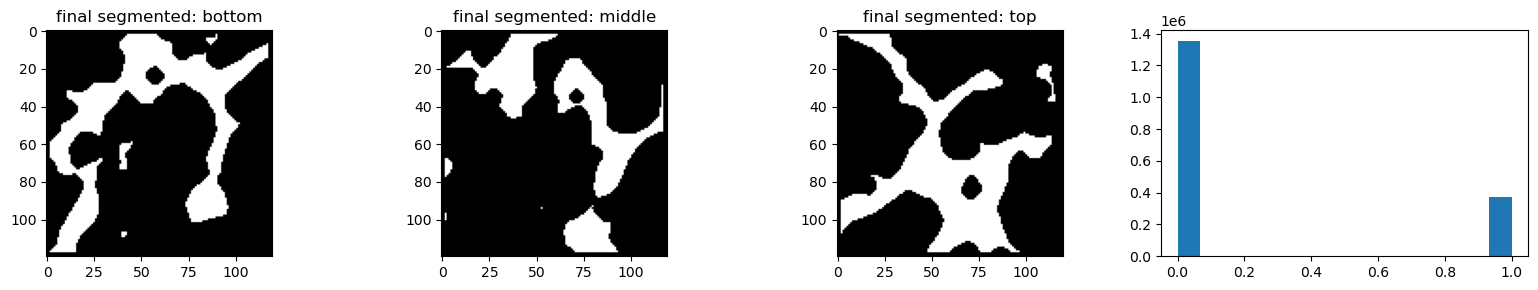

In [10]:
volume_np = out.astype(np.float32)
volume_sitk = sitk.GetImageFromArray(volume_np)

voxel_size = int(1*resize_factor)  # in um, assuming original voxel size is 1 um

## 1. Denoising
## 1.a. Use Curvature Anisotropic Diffusion to denoise while preserving edges

slice_index_z_for_plot = width_inclusive // 2

print("starting filtering pipeline")

t0 = time.time()
denoised = sitk.CurvatureAnisotropicDiffusion(volume_sitk, timeStep=0.0625, conductanceParameter=10, numberOfIterations=30)
print(f"denoised with Curvature Anisotropic Diffusion, time: {time.time()-t0:.2f} s")
plt.imshow(sitk.GetArrayFromImage(denoised)[slice_index_z_for_plot, :, :], cmap='gray')
plt.title("denoised slice"); plt.show()
## 1.b. Clip the image to remove low-valued pixels. Set all pixels < lower to 0, keep others unchanged

t0 = time.time()
clipped_image = sitk.Threshold(denoised, lower=30/255, upper=255/255, outsideValue=0)
print(f"thresholded to remove low-valued pixels, time: {time.time()-t0:.2f} s")
plt.imshow(sitk.GetArrayFromImage(clipped_image)[slice_index_z_for_plot, :, :], cmap='gray')
plt.title("clipped slice"); plt.show()
## 2. Contrast Enhancement: use Adaptive Histogram Equalization so thin faint walls are enhanced before thresholding
## alpha: Controls the degree of local (0.0, highly adaptive) vs global (1.0, less enhancement) contrast enhancement.
## beta: Blends the original image with the enhanced one (0.0: only equalized output | 1.0: original image unchanged)
t0 = time.time()
clahe = sitk.AdaptiveHistogramEqualization(clipped_image, alpha=0.5, beta=0.7)
print(f"contrast enhanced with Adaptive Histogram Equalization, time: {time.time()-t0:.2f} s")
plt.imshow(sitk.GetArrayFromImage(clahe)[slice_index_z_for_plot, :, :], cmap='gray')
plt.title("clahe slice"); plt.show()
## 3. Thresholding: use the mean of the image as a global threshold
t0 = time.time()
binary = sitk.BinaryThreshold(clahe, lowerThreshold=np.mean(clahe), upperThreshold=255/255, outsideValue=0, insideValue=1) # +10
print(f"thresholded to binary image, time: {time.time()-t0:.2f} s")
plt.imshow(sitk.GetArrayFromImage(binary)[slice_index_z_for_plot, :, :], cmap='gray')
plt.title("binary slice"); plt.show()
## Convert back to NumPy for scikit-image postprocessing
t0 = time.time()
binary_np = sitk.GetArrayFromImage(binary).astype(bool)
print(f"converted to NumPy array, time: {time.time()-t0:.2f} s")
## 4. Postprocessing: thin the segmentation and remove small unconnected objects
t0 = time.time()
binary_cleaned = skm.remove_small_objects(binary_np, min_size=(20/voxel_size)**3)
print(f"removed small objects, time: {time.time()-t0:.2f} s")
plt.imshow(binary_cleaned[slice_index_z_for_plot, :, :], cmap='gray')
plt.title("cleaned binary slice"); plt.show()

t0 = time.time()
max_num_iter=2
thinned_3d = []
for i in range(binary_cleaned.shape[0]):
    thinned = skm.thin(binary_cleaned[i, :, :], max_num_iter=max_num_iter)
    thinned_3d.append(thinned)
img_thinned = np.stack(thinned_3d)
print(f"thinned slice-by-slice, time: {time.time()-t0:.2f} s")

t0 = time.time()
thin_cleaned   = skm.remove_small_objects(img_thinned, min_size=(20/voxel_size)**3)
print(f"removed small objects after thinning, time: {time.time()-t0:.2f} s")
t0 = time.time()
img_segmented    = skm.remove_small_holes(thin_cleaned, 125000)
print(f"removed small holes, time: {time.time()-t0:.2f} s")
plt.imshow(img_segmented[slice_index_z_for_plot, :, :], cmap='gray')
plt.title("final segmented slice"); plt.show()

print(f"final porosity segmented: {1.0 - (np.sum(img_segmented) / img_segmented.size):.4f}")

_ = show_four_panel_volume(img_segmented, title_prefix="final segmented", is_binary=True)

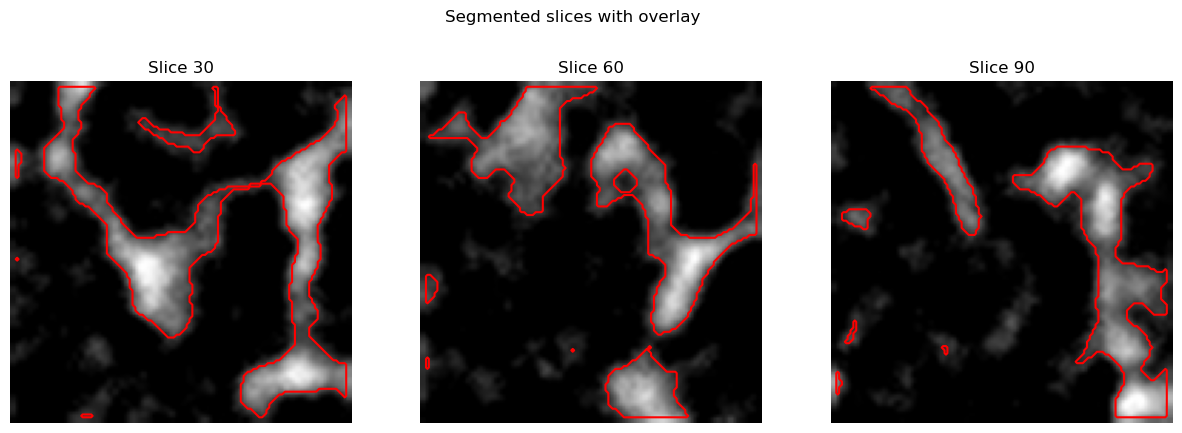

In [11]:
# plot three slices with overlaid segmentations in red 
fig, axes = plt.subplots(1, 3, figsize=(15,5))
slice_indices = [img_segmented.shape[0]//4, img_segmented.shape[0]//2, 3*img_segmented.shape[0]//4]
for ax, idx in zip(axes, slice_indices):
    ax.imshow(volume_np[idx, :, :], cmap='gray')
    ax.contour(img_segmented[idx, :, :], colors='red', levels=[0.5])
    ax.set_title(f"Slice {idx}")
    ax.axis('off')
plt.suptitle("Segmented slices with overlay")
plt.show()

### Meshing

#### pygalmesh

In [5]:
# np.unique(img_segmented.astype(np.uint8), return_counts=True)

In [6]:
# voxel_size_tuple = (voxel_size, voxel_size, voxel_size)  # in um

# mesh = pygm.generate_from_array(
#     img_segmented.astype(np.uint8), voxel_size_tuple, max_facet_distance=2.0, max_cell_circumradius=2.0
# )

#### iso2mesh

In [ ]:
from iso2mesh import v2s, v2m, meshcheckrepair, sms

radbound = 2.0
opts = {"radbound": float(radbound)}
no, el, fc = v2m(img_segmented, 0.5, opts, 1e12, "cgalmesh")


Creating surface and tetrahedral mesh from a multi-domain volume...
Node number: 21233
Triangles: 84296
Tetrahedra: 61188
Regions: 1
Surface and volume meshes complete


In [13]:
view_surface(*matlab_to_python_conv(no, fc), title="v2m")

Widget(value='<iframe src="http://localhost:41263/index.html?ui=P_0x7f2b6ea7c690_0&reconnect=auto" class="pyvi…

In [13]:
print(no.shape, fc.shape)

(21233, 4) (84296, 4)


In [22]:
i2m.savestl(*matlab_to_python_conv(no, fc), "output_before_repair.stl")

In [14]:
def remove_duplicate_faces(no: np.ndarray, fc: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Remove duplicate faces from the mesh.

    Parameters:
    no (np.ndarray): Array of node coordinates.
    fc (np.ndarray): Array of face indices.

    Returns:
    Tuple[np.ndarray, np.ndarray]: Tuple containing the updated node coordinates and face indices.
    """
    # Sort each face's vertex indices to ensure consistent ordering
    sorted_fc = np.sort(fc, axis=1)
    
    # Find unique faces and their indices
    unique_faces, unique_indices = np.unique(sorted_fc, axis=0, return_index=True)
    
    # Select only the unique faces
    fc_unique = fc[unique_indices]

    print(f"original number of faces: {fc.shape[0]}, unique faces: {fc_unique.shape[0]}")
    
    return fc_unique

In [15]:
fc_unique = remove_duplicate_faces(no, fc)
print(f"fc_unique shape: {fc_unique.shape}")
view_surface(*matlab_to_python_conv(no, fc_unique), title="v2m unique faces")

original number of faces: 84296, unique faces: 42148
fc_unique shape: (42148, 4)


Widget(value='<iframe src="http://localhost:45899/index.html?ui=P_0x7f9d6dbfa090_0&reconnect=auto" class="pyvi…

In [16]:
i2m.savestl(*matlab_to_python_conv(no, fc_unique), "output_after_dedup.stl")

output before repair (with duplicate nodes) induces bad result after `pfix.clean_from_arrays(nodes, elems)`

In [ ]:
mesh = meshio.read('./output_before_repair.stl')
nodes = mesh.points
cells_dict = mesh.cells_dict
print(f"cells_dict: {cells_dict}")
elems = mesh.cells_dict['triangle']
print(nodes.shape)
print(elems.shape)


/home/bnherrerac/miniconda3/envs/fenicsx-env/lib/python3.11/site-packages/meshio/stl/_stl.py:40: RuntimeWarning: overflow encountered in scalar multiply
  if 84 + num_triangles * 50 == filesize_bytes:


cells_dict: {'triangle': array([[    0,     1,     2],
       [    0,     1,     2],
       [    0,     1,     3],
       ...,
       [20938, 20939, 20941],
       [20940, 20939, 20941],
       [20940, 20939, 20941]], shape=(84296, 3))}
(20942, 3)
(84296, 3)


In [29]:
# Mesh cleaning (removes degeneracies, self-intersections and isolated nodes)
clean_nodes, clean_elems = pfix.clean_from_arrays(nodes, elems)
print(f"cleaned\nold shapes: nodes {nodes.shape}, elems {elems.shape}\nnew shapes: clean_nodes {clean_nodes.shape}, clean_elems {clean_elems.shape}")
# Checks whether original mesh was already clean
print(np.array_equal(nodes, clean_nodes))
print(np.array_equal(elems, clean_elems))

cleaned
old shapes: nodes (20942, 3), elems (84296, 3)
new shapes: clean_nodes (16, 3), clean_elems (28, 3)
False
False


In [4]:
mesh = meshio.read('./output_after_dedup.stl')
nodes = mesh.points
cells_dict = mesh.cells_dict
print(f"cells_dict: {cells_dict}")
elems = mesh.cells_dict['triangle']
print(nodes.shape)
print(elems.shape)

/home/bnherrerac/miniconda3/envs/fenicsx-env/lib/python3.11/site-packages/meshio/stl/_stl.py:40: RuntimeWarning: overflow encountered in scalar multiply
  if 84 + num_triangles * 50 == filesize_bytes:


cells_dict: {'triangle': array([[    0,     1,     2],
       [    0,     1,     3],
       [    0,     2,     4],
       ...,
       [20933, 20940, 20941],
       [20938, 20939, 20941],
       [20940, 20939, 20941]], shape=(42148, 3))}
(20942, 3)
(42148, 3)


In [7]:
# Mesh cleaning (removes degeneracies, self-intersections and isolated nodes)
clean_nodes, clean_elems = pfix.clean_from_arrays(nodes, elems)
print(f"cleaned\nold shapes: nodes {nodes.shape}, elems {elems.shape}\nnew shapes: clean_nodes {clean_nodes.shape}, clean_elems {clean_elems.shape}")
# Checks whether original mesh was already clean
print(np.array_equal(nodes, clean_nodes))
print(np.array_equal(elems, clean_elems))

cleaned
old shapes: nodes (20942, 3), elems (42148, 3)
new shapes: clean_nodes (20659, 3), clean_elems (41446, 3)
False
False


In [6]:
view_surface(clean_nodes, clean_elems, title="after dedup and pfix cleaning")

Widget(value='<iframe src="http://localhost:39847/index.html?ui=P_0x7fa5402fc3d0_0&reconnect=auto" class="pyvi…

In [7]:
clean_nodes_resampled, clean_elems_resampled = i2m.meshresample(clean_nodes, clean_elems+1, 0.8)
view_surface(*matlab_to_python_conv(clean_nodes_resampled, clean_elems_resampled), title="v2m unique faces")

= Surface Mesh Simplification Utility (Based on CGAL 3.4) =
(modified for iso2mesh by Qianqian Fang)
http://iso2mesh.sf.net

max face ratio=0.800000
edge index number 124338
mesh simplificaton in progress ...

Edges collected: 62169
Edges proccessed: 4211
Edges collapsed: 4145

Edges not collapsed due to topological constrians: 65
Edge not collapsed due to cost computation constrians: 0
Edge not collapsed due to placement computation constrians: 0

Finished...
12435 edges removed.
49734 final edges.


Widget(value='<iframe src="http://localhost:38793/index.html?ui=P_0x7ff6daa647d0_1&reconnect=auto" class="pyvi…

Smoothing after v2m is buggy, it does not in fact smooth the mesh! 

In [39]:
# no, fc = i2m.meshresample(no, fc, 0.2)
# no_smooth = i2m.sms(no, fc_unique, 20, 0.9)
# view_surface(*matlab_to_python_conv(no_smooth, fc_unique), title="v2m")
# view_surface(*matlab_to_python_conv(no, fc_unique), title="v2m")

`i2m.binsurface` generates a non-closed mesh! 

In [40]:
# no_binsurface, fc_binsurface = i2m.binsurface(img_segmented)
# print(fc_binsurface)
# print(fc_binsurface.min())
# no_binsurface, fc_binsurface = i2m.meshresample(no_binsurface, fc_binsurface, 0.2)
# no_binsurface = i2m.sms(no_binsurface, fc_binsurface, 20)

# view_surface(*matlab_to_python_conv(no_binsurface, fc_binsurface), title="binsurface")

In [41]:
# img_segmented_uint8 = img_segmented.astype(np.uint8)
# print(f"unique in img_segmented_uint8 with counts: {np.unique(img_segmented_uint8, return_counts=True)}")
# no_surf, fc_surf, _, _ = v2s(img_segmented_uint8, 0.5, {'distbound': 1})

In [42]:
# def pymeshfix_clean(V: np.ndarray, F: np.ndarray) -> tuple[np.ndarray,np.ndarray]:
#     print(f"[pymeshfix_clean] Input mesh: {len(V)} vertices, {len(F)} faces")
#     mfx = pfix.MeshFix(V, F)
#     # print(f"[pymeshfix_clean] Initial mesh: {mfx.mesh_clean.n_vertices} vertices, {mfx.mesh_clean.n_faces} faces, {mfx.mesh_clean.n_edges} edges.")
#     print(f"[pymeshfix_clean] repairing...")
#     mfx.repair(verbose=False, joincomp=True, remove_smallest_components=False)
#     Vc, Fc = mfx.v, mfx.f #.reshape(-1,4)[:,1:]
#     print(f"[pymeshfix_clean] Output mesh: VC shape = {Vc.shape}, Fc shape = {Fc.shape}")
#     return Vc, Fc

In [43]:
# vc, fc = pymeshfix_clean(*matlab_to_python_conv(no, fc_unique))
# view_surface(vc, fc, title="pymeshfix cleaned v2m")

In [8]:
# print(f"number of nodes/faces = {no.shape[0]}/{fc.shape[0]}")
# no_clean, fc_clean  = pfix.clean_from_arrays(no, fc[:,:3])
# print(f"number of nodes/faces after pymeshfix = {no_clean.shape[0]}/{fc_clean.shape[0]}")
# # Checks whether original mesh was already clean
# print(np.array_equal(no, no_clean))
# print(np.array_equal(fc, fc_clean))

In [9]:
# Trimesh object generation, not used so far
mesh = trimesh.Trimesh(vertices=clean_nodes_resampled,
      faces = clean_elems_resampled - 1)

# TetGen object, for tetrahedralization
tetra_mesh = tetgen.TetGen(clean_nodes_resampled, clean_elems_resampled)



In [10]:
# trimesh bounds
mesh.bounds

array([[  0.451768,   1.2204  ,   1.94187 ],
       [119.549   , 118.048   , 118.048   ]])

In [ ]:
# Unused
# tetra_mesh.make_manifold()

In [ ]:
# TetGen tetrahedralization
tnodes, telems = tetra_mesh.tetrahedralize(order=1, minratio=1.1, quality=True)

### Clipping and flattening

In [19]:
def _pv_from_VF(V: np.ndarray, F: np.ndarray) -> pv.PolyData:
    return pv.PolyData(V, np.hstack([np.full((len(F),1),3), F]).ravel())

def clip_and_cap_box(V: np.ndarray, 
                     F: np.ndarray, 
                     L: tuple[float,float,float],
                     tol: float=1e-12) -> tuple[np.ndarray,np.ndarray,np.ndarray]:
    """
    Sequentially clip with 6 planes and cap. Return (Vcap, Fcap, labels),
    where labels is per-triangle: 0=interior wall, 1..6 = x_min,x_max,y_min,y_max,z_min,z_max.
    """
    print(f"[clip_and_cap_box] Input mesh: {len(V)} vertices, {len(F)} faces, box L={L}")
    Lx,Ly,Lz = L
    mesh = _pv_from_VF(V,F)

    def closed_clip(m: pv.PolyData, normal, origin) -> pv.PolyData:
        return m.clip_closed_surface(normal=normal, origin=origin, inplace=False)

    # Clip to the box
    m = mesh
    m = closed_clip(m, ( 1,0,0), (0,0,0))
    m = closed_clip(m, (-1,0,0), (Lx,0,0))
    m = closed_clip(m, (0, 1,0), (0,0,0))
    m = closed_clip(m, (0,-1,0), (0,Ly,0))
    m = closed_clip(m, (0,0, 1), (0,0,0))
    m = closed_clip(m, (0,0,-1), (0,0,Lz))
    m = m.triangulate()

    Vc = np.asarray(m.points)
    Fc = np.asarray(m.faces.reshape(-1,4)[:,1:])

    # Label triangles by planarity
    labels = np.zeros(len(Fc), dtype=np.int32)
    P = Vc
    def near(a,b): return abs(a-b) <= tol
    for i, tri in enumerate(Fc):
        pts = P[tri]
        if np.allclose(pts[:,0], 0.0, atol=tol):   labels[i]=1
        elif np.allclose(pts[:,0], Lx,  atol=tol): labels[i]=2
        elif np.allclose(pts[:,1], 0.0, atol=tol): labels[i]=3
        elif np.allclose(pts[:,1], Ly,  atol=tol): labels[i]=4
        elif np.allclose(pts[:,2], 0.0, atol=tol): labels[i]=5
        elif np.allclose(pts[:,2], Lz,  atol=tol): labels[i]=6
        else: labels[i]=0
    # Snap cap vertices exactly to planes
    P2 = P.copy()
    eps = tol
    P2[np.isclose(P2[:,0], 0.0, atol=eps),0] = 0.0
    P2[np.isclose(P2[:,0], Lx,  atol=eps),0] = Lx
    P2[np.isclose(P2[:,1], 0.0, atol=eps),1] = 0.0
    P2[np.isclose(P2[:,1], Ly,  atol=eps),1] = Ly
    P2[np.isclose(P2[:,2], 0.0, atol=eps),2] = 0.0
    P2[np.isclose(P2[:,2], Lz,  atol=eps),2] = Lz

    # Print cap label counts
    cap_counts = {lab: (labels==lab).sum() for lab in range(7)}
    print(f"[clip_and_cap_box] Cap label counts: {cap_counts}")
    print(f"[clip_and_cap_box] Output mesh: {len(P2)} vertices, {len(Fc)} faces")
    return P2, Fc, labels

In [20]:
P2, Fc, labels = clip_and_cap_box(V_vox, F0, (width_inclusive,width_inclusive,width_inclusive), tol=1e-12)
view_surface(P2, Fc, title="clipped and capped surface (voxel units)")

[clip_and_cap_box] Input mesh: 5314 vertices, 21396 faces, box L=(50, 50, 50)


ValueError: This surface appears to be non-manifold.

### Periodization

In [ ]:
# from typing import List, Dict

# def translation(dx: float, dy: float, dz: float) -> List[float]:
#     print(f"[translation] dx={dx}, dy={dy}, dz={dz}")
#     T = [1,0,0,dx, 0,1,0,dy, 0,0,1,dz, 0,0,0,1]
#     print(f"[translation] T={T}")
#     return T


# def _face_tris(face: int) -> set[tuple[int,int,int]]:
#     types, etags, enodes = gmsh.model.mesh.getElements(2, face)
#     tris: set[tuple[int,int,int]] = set()
#     for typ, nodes in zip(types, enodes):
#         name, _, _, nNodes, *_ = gmsh.model.mesh.getElementProperties(typ)
#         if name.lower().startswith("triangle"):
#             for i in range(0, len(nodes), nNodes):
#                 tris.add(tuple(sorted((int(nodes[i]), int(nodes[i+1]), int(nodes[i+2])))))
#     if tris: return tris
#     # fallback: skin from tets
#     faceNodes,_,_ = gmsh.model.mesh.getNodes(2, face)
#     S = set(int(t) for t in faceNodes.tolist())
#     tetT = gmsh.model.mesh.getElementType("tetrahedron", 1)
#     _,_,C = gmsh.model.mesh.getElementsByType(tetT)
#     FIDX = [(0,1,2),(0,1,3),(0,2,3),(1,2,3)]
#     tris = set()
#     for i in range(0, len(C), 4):
#         tet = [int(C[i+j]) for j in range(4)]
#         for a,b,c in FIDX:
#             tri = (tet[a],tet[b],tet[c])
#             if tri[0] in S and tri[1] in S and tri[2] in S:
#                 tris.add(tuple(sorted(tri)))
#     return tris

# def verify_pair(slave_face: int, master_face: int, Texp: List[float],
#                 tol_geom: float=1e-12, tol_coords: float=1e-12) -> dict:
#     tagM, sTags, mTags, A = gmsh.model.mesh.getPeriodicNodes(2, slave_face, False)
#     # coords error
#     allTags, xyz, _ = gmsh.model.mesh.getNodes()
#     coords = {int(t):(xyz[3*i],xyz[3*i+1],xyz[3*i+2]) for i,t in enumerate(allTags)}
#     dx,dy,dz = Texp[3],Texp[7],Texp[11]
#     err = 0.0
#     s2m: Dict[int,int] = {}
#     for s,m in zip(sTags, mTags):
#         ps, pm = coords[int(s)], coords[int(m)]
#         err = max(err, max(abs(ps[0]-(pm[0]+dx)), abs(ps[1]-(pm[1]+dy)), abs(ps[2]-(pm[2]+dz))))
#         s2m[int(s)] = int(m)
#     # triangles
#     SL, MS = _face_tris(slave_face), _face_tris(master_face)
#     mapped = set(tuple(sorted((s2m[a], s2m[b], s2m[c]))) for (a,b,c) in SL if a in s2m and b in s2m and c in s2m)
#     return {
#         "pairs": len(sTags),
#         "ok_affine": all(abs(a-b)<=tol_geom for a,b in zip(A, Texp)),
#         "max_coord_err_inf": float(err),
#         "ok_triangles": (not SL and not MS) or (mapped == MS),
#         "n_tris_slave": len(SL), "n_tris_master": len(MS), "n_tris_mapped": len(mapped)
#     }

In [ ]:

# def _T(dx: float, dy: float, dz: float) -> List[float]:
#     return [1,0,0,dx, 0,1,0,dy, 0,0,1,dz, 0,0,0,1]

# def _add_discrete_surface(tag: int, V: np.ndarray, tris: np.ndarray, node_offset: int=0):
#     gmsh.model.addDiscreteEntity(2, tag)
#     # Build unique-node map for this surface
#     u, inv = np.unique(tris, return_inverse=True)
#     node_tags = (u + 1 + node_offset).astype(np.int64)
#     coords = V[u].ravel().tolist()
#     gmsh.model.mesh.addNodes(2, tag, node_tags.tolist(), coords)
#     etype = gmsh.model.mesh.getElementType("triangle", 1)
#     elemTags = np.arange(1, tris.shape[0]+1, dtype=np.int64)
#     conn = (node_tags[inv].reshape(-1,3)).ravel().tolist()
#     gmsh.model.mesh.addElements(2, tag, [etype], [elemTags.tolist()], [conn])

# def mesh_periodic_from_labeled_faces(V: np.ndarray, F: np.ndarray, labels: np.ndarray,
#                                      L: Tuple[float,float,float],
#                                      h_surf: float, h_vol: float) -> tuple[np.ndarray,np.ndarray,Dict]:
#     """
#     Build discrete surfaces for: 1..6 caps and 0 interior; define a discrete volume; set periodicity on caps; mesh 3D.
#     Returns (P, T, meta) with periodic maps.
#     """
#     print(f"[mesh_periodic_from_labeled_faces] Input mesh: {len(V)} vertices, {len(F)} faces, box L={L}, h_surf={h_surf}, h_vol={h_vol}")
#     gmsh.initialize()
#     gmsh.model.add("alveoRVE_cell")
#     Lx,Ly,Lz = L

#     # Split faces by label
#     faces = {lab: F[labels==lab] for lab in range(0,7) if np.any(labels==lab)}
#     print(f"[mesh_periodic_from_labeled_faces] Cap faces: {{lab: len(tris) for lab, tris in faces.items()}}")
#     # Create each surface as a discrete entity with its own nodes
#     tag_map: Dict[int,int] = {}  # label -> surface tag
#     node_offset = 0
#     for lab, tris in faces.items():
#         tag = 100 + lab
#         _add_discrete_surface(tag, V, tris, node_offset=node_offset)
#         tag_map[lab] = tag
#         node_offset += V.shape[0]  # ensure disjoint tag ranges per surface

#     # Create a discrete volume bounded by all surfaces
#     vol_tag = 200
#     gmsh.model.addDiscreteEntity(3, vol_tag, [tag_map[lab] for lab in faces.keys()])

#     # Periodicity on six caps; edges/points may not exist in discrete geometry -> 2D is enough
#     if 1 in tag_map and 2 in tag_map:
#         gmsh.model.mesh.setPeriodic(2, [tag_map[2]], [tag_map[1]], _T(Lx,0,0))
#         print(f"[mesh_periodic_from_labeled_faces] Set periodicity: x faces (1,2)")
#     if 3 in tag_map and 4 in tag_map:
#         gmsh.model.mesh.setPeriodic(2, [tag_map[4]], [tag_map[3]], _T(0,Ly,0))
#         print(f"[mesh_periodic_from_labeled_faces] Set periodicity: y faces (3,4)")
#     if 5 in tag_map and 6 in tag_map:
#         gmsh.model.mesh.setPeriodic(2, [tag_map[6]], [tag_map[5]], _T(0,0,Lz))
#         print(f"[mesh_periodic_from_labeled_faces] Set periodicity: z faces (5,6)")

#     # Size fields
#     gmsh.option.setNumber("Mesh.CharacteristicLengthMin", min(h_surf, h_vol))
#     gmsh.option.setNumber("Mesh.CharacteristicLengthMax", max(h_surf, h_vol))
#     gmsh.model.mesh.generate(3)
#     print(f"[mesh_periodic_from_labeled_faces] Mesh generation complete.")

#     # Extract nodes/tets
#     tags, coords, _ = gmsh.model.mesh.getNodes()
#     P = np.asarray(coords, dtype=float).reshape(-1,3)
#     etype = gmsh.model.mesh.getElementType("tetrahedron", 1)
#     _, _, conn = gmsh.model.mesh.getElementsByType(etype)
#     T = np.asarray(conn, dtype=np.int64).reshape(-1,4) - 1

#     meta = {"caps": tag_map, "volume": vol_tag, "L": L}
#     print(f"[mesh_periodic_from_labeled_faces] Output mesh: {len(P)} nodes, {len(T)} tets")
#     gmsh.finalize()
#     return P, T, meta

In [ ]:
# mins = V_vox.min(0); maxs = V_vox.max(0); span = (maxs - mins)
# V_unit = (V_vox - mins) / span
# Vcap, Fcap, labels = clip_and_cap_box(V_unit, F0, (1,1,1))
# print(f"[cap] caps: x- {(labels==1).sum()} x+ {(labels==2).sum()} | y- {(labels==3).sum()} y+ {(labels==4).sum()} | z- {(labels==5).sum()} z+ {(labels==6).sum()}")

# # mesh
# h_surf = 2*1.0 / float(span.max())  # convert your 2*res_um to unit-box
# h_vol  = 3*h_surf
# P, T, meta = mesh_periodic_from_labeled_faces(Vcap, Fcap, labels, (1,1,1), h_surf, h_vol)
# print(f"[mesh] Nodes={len(P):,}, Tets={len(T):,}")

# # verify (same logic you liked in the cylinder tests)
# import gmsh
# # faces (slave, master) from meta["caps"]: 1..6 = x-,x+,y-,y+,z-,z+
# xslave, xmaster = meta["caps"][2], meta["caps"][1]
# yslave, ymaster = meta["caps"][4], meta["caps"][3]
# zslave, zmaster = meta["caps"][6], meta["caps"][5]
# vx = verify_pair(xslave, xmaster, translation(1,0,0))
# vy = verify_pair(yslave, ymaster, translation(0,1,0))
# vz = verify_pair(zslave, zmaster, translation(0,0,1))
# print(f"[verify x] pairs={vx['pairs']} maxerr={vx['max_coord_err_inf']:.3e} tris={vx['n_tris_slave']}/{vx['n_tris_master']} ok={vx['ok_triangles']}")
# print(f"[verify y] pairs={vy['pairs']} maxerr={vy['max_coord_err_inf']:.3e} tris={vy['n_tris_slave']}/{vy['n_tris_master']} ok={vy['ok_triangles']}")
# print(f"[verify z] pairs={vz['pairs']} maxerr={vz['max_coord_err_inf']:.3e} tris={vz['n_tris_slave']}/{vz['n_tris_master']} ok={vz['ok_triangles']}")

In [ ]:
# view_surface(P, Fcap, title="final capped surface (unit box)")

In [ ]:
# Surface repair → smooth/decimate → clip & cap to RVE box
import numpy as np
from alveoRVE.surface.repair import pymeshfix_clean, taubin_smooth, decimate_preserve_shape, clean_tri_mesh
from alveoRVE.surface.clip import clip_and_cap_box
# from alveoRVE.meshing.gmsh_periodic import mesh_periodic_from_labeled_faces

# Inputs expected from previous cells: V_vox, F0
V0 = V_vox
F0i = F0.astype(np.int64)
print(f"start: V={len(V0)}, F={len(F0i)}")

# 1) Repair manifoldness (pymeshfix), fallback to simple clean
try:
    V1, F1 = pymeshfix_clean(V0, F0i)
except Exception as e:
    print("pymeshfix_clean failed, using clean_tri_mesh:", e)
    V1, F1 = clean_tri_mesh(V0, F0i)

In [53]:
view_surface(V1, F1, title="final capped surface (unit box)")

Widget(value='<iframe src="http://localhost:46721/index.html?ui=P_0x7fb9343e03d0_9&reconnect=auto" class="pyvi…

In [ ]:


# 2) Smooth (Taubin, shape-preserving)
V2, F2 = taubin_smooth(V1, F1, n_iter=20, pass_band=0.1)

# 3) Optional decimation while preserving features
reduction = 0.20  # 20% reduction
V3, F3 = decimate_preserve_shape(V2, F2, reduction=reduction, feature_angle=35.0)

# 4) Build RVE bounds (prefer explicit variables if defined)
if 'size_rve_x' in globals() and 'size_rve_y' in globals() and 'size_rve_z' in globals():
    Lx, Ly, Lz = float(size_rve_x), float(size_rve_y), float(size_rve_z)
    if 'offset_rve_x' in globals() and 'offset_rve_y' in globals() and 'offset_rve_z' in globals():
        xmin = float(offset_rve_x); ymin = float(offset_rve_y); zmin = float(offset_rve_z)
        bounds = (xmin, xmin+Lx, ymin, ymin+Ly, zmin, zmin+Lz)
    else:
        cx, cy, cz = V3.mean(0)
        bounds = (cx - Lx/2, cx + Lx/2, cy - Ly/2, cy + Ly/2, cz - Lz/2, cz + Lz/2)
else:
    xmin, xmax = V3[:,0].min(), V3[:,0].max()
    ymin, ymax = V3[:,1].min(), V3[:,1].max()
    zmin, zmax = V3[:,2].min(), V3[:,2].max()
    bounds = (float(xmin), float(xmax), float(ymin), float(ymax), float(zmin), float(zmax))
L = (bounds[1]-bounds[0], bounds[3]-bounds[2], bounds[5]-bounds[4])
print("RVE bounds:", bounds, " L:", L)

# 5) Clip and cap, label faces
Vc, Fc, labels, used_bounds = clip_and_cap_box(V3, F3, bounds=bounds, tol=1e-6, max_hole_size=1e9)
print("Cap label counts:", {i:int((labels==i).sum()) for i in range(7)})

# 6) (Optional) Mesh periodic 3D volume — leave commented for now to avoid heavy compute
# h_surf = min(L)/10
# h_vol  = min(L)/6
# P, T, meta = mesh_periodic_from_labeled_faces(Vc, Fc, labels, L, h_surf, h_vol)
# print(f"Tet mesh: {len(P)} nodes, {len(T)} tets")
